# Programming Exercise 6:
# Support Vector Machines

In this exercise, we will implement Support Vector Machines (SVM) to build a spam classifier.

In [166]:
#used for manipulating 
import os
#user for numnerical array computation
import numpy as np
#used for manipulating dataframe
import pandas as pd
#optimization module in scipy
from scipy.optimize import minimize
#method to load matlab file
from scipy.io import loadmat
#data visualization
from matplotlib import pyplot as plt 
#import regular expression
import re
from sklearn.svm import SVC
#utils
import utils

%matplotlib inline

In [4]:
#create a function to plot 2D data
def plotData(X, y, grid=False):
    """
    Plots the data points X and y into a new figure. Uses `+` for positive examples, and `o` for
    negative examples. `X` is assumed to be a Mx2 matrix

    Parameters
    ----------
    X : numpy ndarray
        X is assumed to be a Mx2 matrix.

    y : numpy ndarray
        The data labels.

    grid : bool (Optional)
        Specify whether or not to show the grid in the plot. It is False by default.

    Notes
    -----
    This was slightly modified such that it expects y=1 or y=0.
    """
    
    y = y.flatten() if y.ndim > 1 else y
    neg, pos = y == 0, y == 1

    plt.plot(X[pos, 0], X[pos, 1], 'X', ms=10, mec='k')
    plt.plot(X[neg, 0], X[neg, 1], 'o', mfc='yellow', ms=10, mec='k')
    if grid:
        plt.grid()

In [5]:
def visualizeBoundaryLinear(svc, X, y):
    y = y.flatten() if y.ndim > 1 else y
    x1 = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
    x2 = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
    xx, yy = np.meshgrid(x1, x2)
    Z = svc.predict(np.c_[xx.flatten(), yy.flatten()])
    plt.figure(figsize=(10, 10))
    plt.contour(xx, yy, Z.reshape(xx.shape), levels=[0.5], colors='blue')
    
    #plot feature 1 & 2 of X on x- and y- axis of the plot
    plotData(X, y)
    
    plt.xlim(X[:, 0].min(), X[:, 0].max())
    plt.ylim(X[:, 1].min(), X[:, 1].max())
    plt.ylabel('$X2$', rotation=365)
    plt.xlabel('$X1$');
    

In [228]:
def getVocab():
    file = open(os.path.join('Data', 'vocab.txt'))
    vocab = file.read()
    onlyWord = re.compile('[0-9\W]')
    vocab = re.sub(onlyWord, " ", vocab).split()
    return vocab

## 1 Support Vector Machines

In this part, we will be using support vector machines with various example 2D datasets, thus gaining an intuition of how SVM & SVM with Gaussian kernel really work. The other half is about the use of SVM to build spam classifier.

In [6]:
#load dataset from matlab file
data = loadmat(os.path.join('Data', 'ex6data1.mat'))
X, y = data['X'], data['y'].flatten()

print('X.shape: %s\nY.shape: %s'%(X.shape, y.shape)) # 51 training example with 2 features

X.shape: (51, 2)
Y.shape: (51,)


In [7]:
np.unique(y) # 2 class labels, 0 as non-spam and 1 as spam

array([0, 1], dtype=uint8)

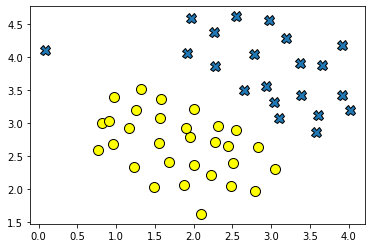

In [8]:
plotData(X, y, False)

In this part of exercise, we will use different values of $C$ parameter in cost function of SVM. $C$ plays a role in controlling the penalty for misclassified training examples. A large $C$ tells SVM to try to classify all the training examples correctly. In general, $C$ is equivalent to $1\/lambda$, , where $\lambda$ is the regularization parameter that we were using previously for logistic regression.

Our task is to try different values of $C$ on this dataset. Specifically, we should change the value of $C$ in the next cell to $C = 100$ and run the SVM training again. When $C = 100$, we should find that the SVM now classifies every single example correctly, but has a decision boundary that does not appear to be a natural fit for the data (similarly speaking, SVM fit is very sensitive to every single example once C gets increased to a large value).

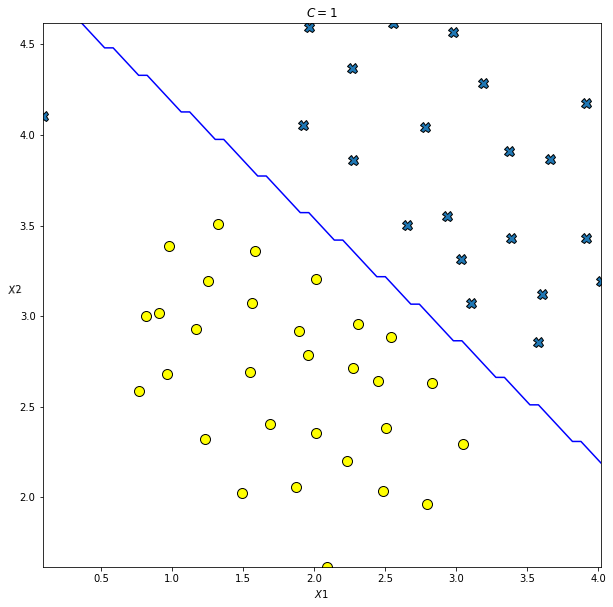

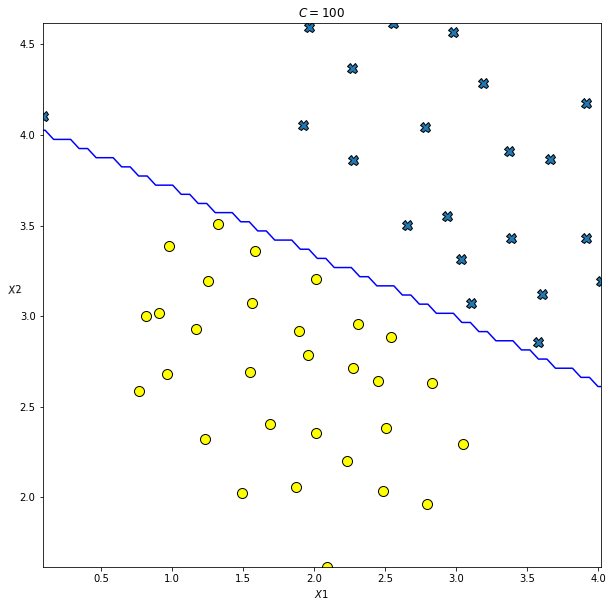

In [9]:
#try different values of C to see how decision boundary changes
C = 1
svc = SVC(C=C, kernel='linear')
svc.fit(X, y)
visualizeBoundaryLinear(svc, X,  y)
plt.title("$C=1$");
C = 100
svc = SVC(C=C, kernel='linear')
svc.fit(X, y)
visualizeBoundaryLinear(svc, X,  y)
plt.title("$C=100$");

### 1.2 SVM with Gaussian Kernels

In this part of the exercise, we will be using SVMs to do non-linear classification. In particular, you will be using SVMs with Gaussian kernels on datasets that are not linearly separable.

#### 1.2.1 Gaussian Kernel

To find non-linear decision boundaries with the SVM, we need to first implement a Gaussian kernel. We can think of the Gaussian kernel as a similarity function that measures the “distance” between a pair of examples,
($x^{(i)}$, $x^{(j)}$). The Gaussian kernel is also parameterized by a bandwidth parameter, $\sigma$, which determines how fast the similarity metric decreases (to 0) as the examples are further apart.
We should now complete the code in `gaussianKernel` to compute the Gaussian kernel between two examples, ($x^{(i)}$, $x^{(j)}$). The Gaussian kernel function is defined as:

$$ K_{\text{gaussian}} \left( x^{(i)}, x^{(j)} \right) = \exp \left( - \frac{\left\lvert\left\lvert x^{(i)} - x^{(j)}\right\lvert\right\lvert^2}{2\sigma^2} \right) = \exp \left( -\frac{\sum_{k=1}^n \left( x_k^{(i)} - x_k^{(j)}\right)^2}{2\sigma^2} \right)$$
<a id="gaussianKernel"></a>

In [10]:
def gaussianKernel(x1, x2, sigma):
    """
    Computes the radial basis function
    Returns a radial basis function kernel between x1 and x2.
    
    Parameters
    ----------
    x1 :  numpy ndarray
        A vector of size (n, ), representing the first datapoint.
    
    x2 : numpy ndarray
        A vector of size (n, ), representing the second datapoint.
    
    sigma : float
        The bandwidth parameter for the Gaussian kernel.

    Returns
    -------
    sim : float
        The computed RBF between the two provided data points.
    
    """
    sim = np.exp(-np.linalg.norm(x1-x2) ** 2 / (2 * sigma ** 2))
    
    return sim

### 1.2.2 Example Dataset 2

The next part in this notebook will load and plot dataset 2, as shown in the figure below. 

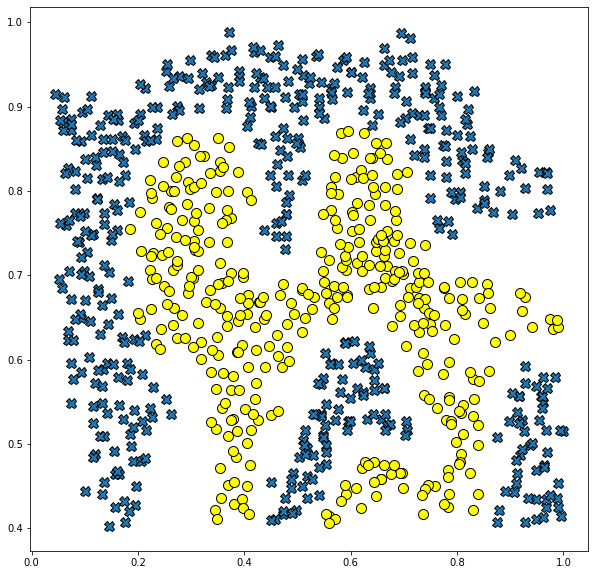

In [11]:
#load data 2 
data = loadmat(os.path.join('Data', 'ex6data2.mat'))
X, y = data["X"], data["y"]

#plot data
plotData(X, y)
plt.gcf().set_size_inches(10, 10);

From the figure, we can obserse that there is no linear decision boundary that separates the positive and negative examples for this dataset. However, by using the Gaussian kernel with the SVM, we will be able to learn a non-linear decision boundary that can perform reasonably well for the dataset. If we have correctly implemented the Gaussian kernel function, the following cell will proceed to train the SVM with the Gaussian kernel on this dataset.

We should get a decision boundary as shown in the figure below, as computed by the SVM with a Gaussian kernel. The decision boundary is able to separate most of the positive and negative examples correctly and follows the contours of the dataset well.

C:\Users\lamtr\anaconda3\envs\clone_3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


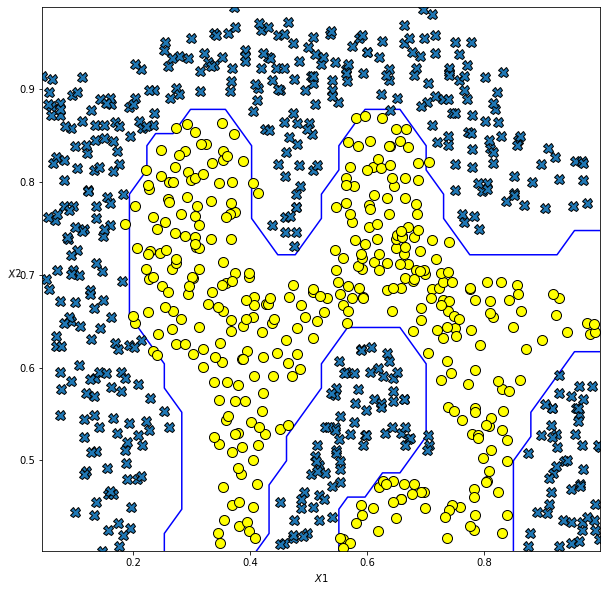

In [12]:
#fit SVM into the dataset 2
svc = SVC(C=1, kernel='rbf', gamma=50)
svc.fit(X, y)
visualizeBoundaryLinear(svc, X, y)

### 1.2.3 Example Dataset 3

In this part of the exercise, we will gain more practical skills on how to use a SVM with a Gaussian kernel. The next cell will load and display a third dataset, which should look like the figure below

In [13]:
#load data 3
data = loadmat(os.path.join('Data', 'ex6data3.mat'))
X, Xval, y, yval = data["X"], data["Xval"], data["y"].flatten(), data["yval"].flatten()
print(X.shape, y.shape)
print(Xval.shape, yval.shape)

(211, 2) (211,)
(200, 2) (200,)


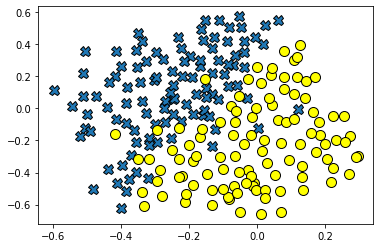

In [14]:
plotData(X, y)

Our task is to use the cross validation set `Xval`, `yval` to determine the best $C$ and $\sigma$ parameter to use. We should write any additional code necessary to help us search over the parameters $C$ and $\sigma$. For both $C$ and $\sigma$, it is  suggested trying values in multiplicative steps (e.g., 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30).
Note that we should try all possible pairs of values for $C$ and $\sigma$ (e.g., $C = 0.3$ and $\sigma = 0.1$). For example, if we try each of the 8 values listed above for $C$ and for $\sigma^2$, we would end up training and evaluating (on the cross validation set) a total of $8^2 = 64$ different models. After we have determined the best $C$ and $\sigma$ parameters to use, we should modify the code in `dataset3Params`, filling in the best parameters you found. For our best parameters, the SVM returned a decision boundary shown in the figure below. 

In [15]:
def dataset3Params(X, y, Xval, yval):
    """
    Returns your choice of C and sigma for Part 3 of the exercise 
    where you select the optimal (C, sigma) learning parameters to use for SVM
    with RBF kernel.
    
    Parameters
    ----------
    X : array_like
        (m x n) matrix of training data where m is number of training examples, and 
        n is the number of features.
    
    y : array_like
        (m, ) vector of labels for ther training data.
    
    Xval : array_like
        (mv x n) matrix of validation data where mv is the number of validation examples
        and n is the number of features
    
    yval : array_like
        (mv, ) vector of labels for the validation data.
    
    Returns
    -------
    C, sigma : float, float
        The best performing values for the regularization parameter C and 
        RBF parameter sigma.
    
    Instructions
    ------------
    Fill in this function to return the optimal C and sigma learning 
    parameters found using the cross validation set.
    You can use `svmPredict` to predict the labels on the cross
    validation set. For example, 
    
        predictions = svmPredict(model, Xval)

    will return the predictions on the cross validation set.
    
    Note
    ----
    You can compute the prediction error using 
    
        np.mean(predictions != yval)
    """
    # You need to return the following variables correctly.
    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score
    
    C = 1
    sigma = 0.3

    # ====================== YOUR CODE HERE ======================
    test_params = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    C_list, sigma_list = np.meshgrid(test_params, test_params)
    C_list, sigma_list = C_list.flatten(), sigma_list.flatten()
    error = np.zeros(C_list.shape)
    for i in range(len(C_list)):
        gamma = (1 / (2 * sigma_list[i] ** 2))
        svc = SVC(C=C_list[i], gamma=gamma, kernel='rbf')
        svc.fit(X, y)
        ypred = svc.predict(Xval)
        error[i] = 1 - accuracy_score(yval, ypred)
            
    min_ind = np.argmin(error)
    C = C_list[min_ind]
    sigma = sigma_list[min_ind]
    # ============================================================
    return C, sigma

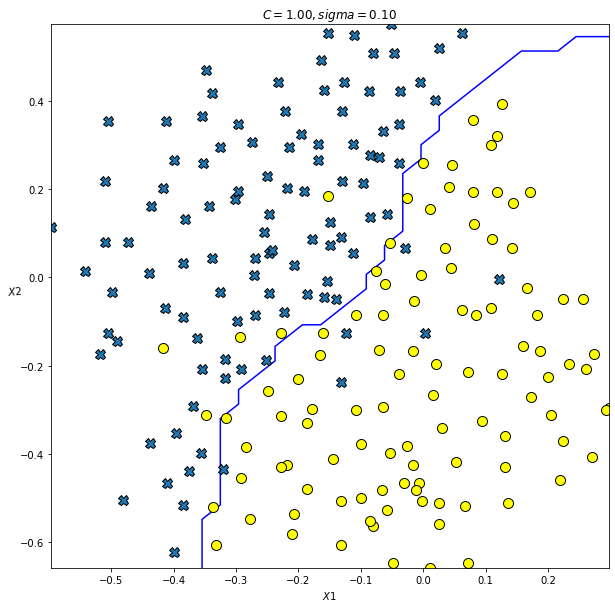

In [16]:
# Try different SVM Parameters here
C, sigma = dataset3Params(X, y, Xval, yval)
#train thr svm given optimal C, sigma
svc = SVC(C=C, gamma=(1/(2*sigma**2)))
svc.fit(X, y)
visualizeBoundaryLinear(svc, X, y)
plt.title('$C=%.2f,  sigma=%.2f$'%(C, sigma));

## 2 Spam Classification

Many email services today provide spam filters that are able to classify emails into spam and non-spam email with high accuracy. In this part of the exercise, we will use SVMs to build our own spam filter.

We will be training a classifier to classify whether a given email, $x$, is spam ($y = 1$) or non-spam ($y = 0$). In particular, we need to convert each email into a feature vector $x \in \mathbb{R}^n$ . The following parts of the exercise we walk  through how such a feature vector can be constructed from an email.

The dataset included for this exercise is based on a a subset of the [SpamAssassin Public Corpus](http://spamassassin.apache.org/old/publiccorpus/). For the purpose of this exercise, we will only be using the body of the email (excluding the email headers).

### 2.1 Preprocessing Emails

Before starting on a machine learning task, it is usually insightful to take a look at examples from the dataset. The figure below shows a sample email that contains a URL, an email address (at the end), numbers, and dollar
amounts.

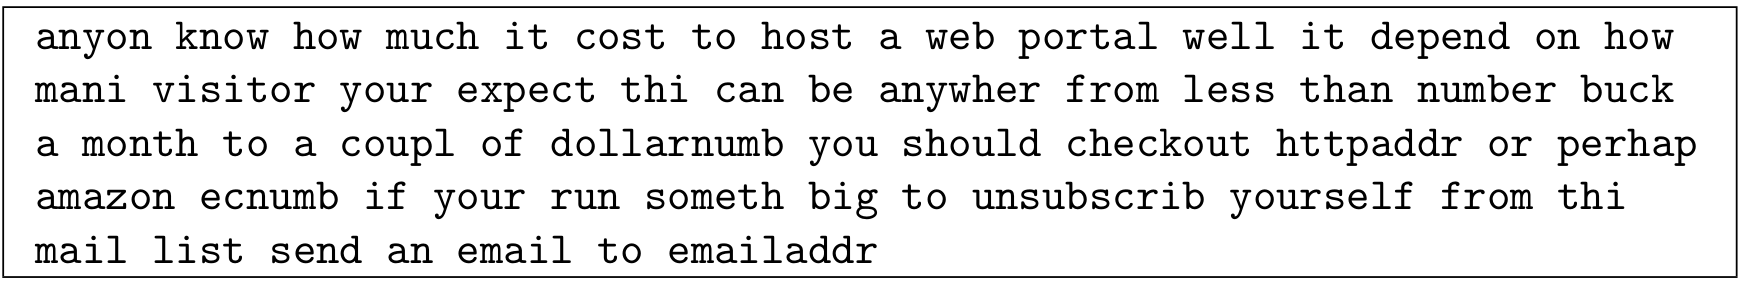

While many emails would contain similar types of entities (e.g., numbers, other URLs, or other email addresses), the specific entities (e.g., the specific URL or specific dollar amount) will be different in almost every
email. Therefore, one method often employed in processing emails is to “normalize” these values, so that all URLs are treated the same, all numbers are treated the same, etc. For example, we could replace each URL in the
email with the unique string “httpaddr” to indicate that a URL was present.

This has the effect of letting the spam classifier make a classification decision based on whether any URL was present, rather than whether a specific URL was present. This typically improves the performance of a spam classifier, since spammers often randomize the URLs, and thus the odds of seeing any particular URL again in a new piece of spam is very small. 

In the function `processEmail` below, we have implemented the following email preprocessing and normalization steps:

- **Lower-casing**: The entire email is converted into lower case, so that captialization is ignored (e.g., IndIcaTE is treated the same as Indicate).

- **Stripping HTML**: All HTML tags are removed from the emails. Many emails often come with HTML formatting; we remove all the HTML tags, so that only the content remains.

- **Normalizing URLs**: All URLs are replaced with the text “httpaddr”.

- **Normalizing Email Addresses**:  All email addresses are replaced with the text “emailaddr”.

- **Normalizing Numbers**: All numbers are replaced with the text “number”.

- **Normalizing Dollars**: All dollar signs ($) are replaced with the text “dollar”.

- **Word Stemming**: Words are reduced to their stemmed form. For example, “discount”, “discounts”, “discounted” and “discounting” are all replaced with “discount”. Sometimes, the Stemmer actually strips off additional characters from the end, so “include”, “includes”, “included”, and “including” are all replaced with “includ”.

- **Removal of non-words**: Non-words and punctuation have been removed. All white spaces (tabs, newlines, spaces) have all been trimmed to a single space character.

The result of these preprocessing steps is shown in the figure below. 

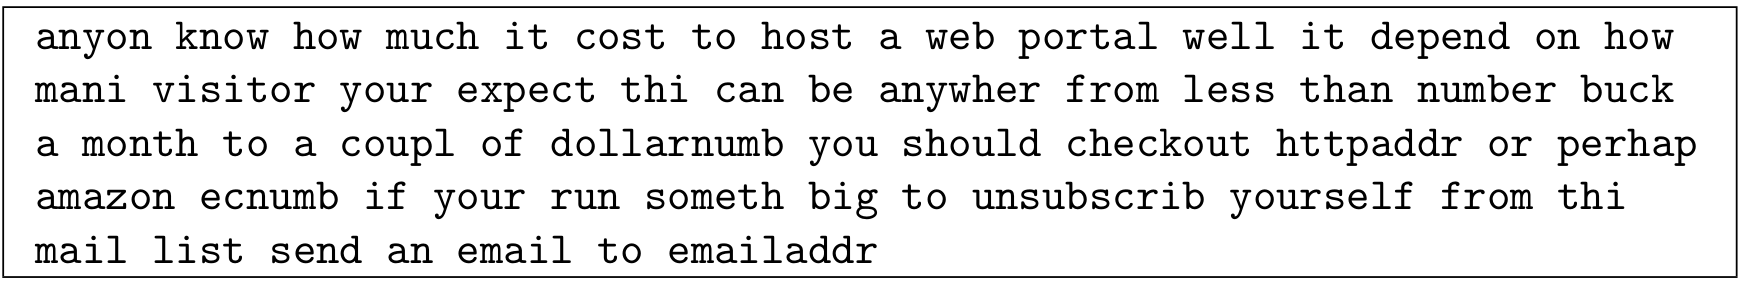

While preprocessing has left word fragments and non-words, this form turns out to be much easier to work with for performing feature extraction.

#### 2.1.1 Vocabulary List

After preprocessing the emails, we have a list of words for each email. The next step is to choose which words we would like to use in our classifier and which we would want to leave out.

For this exercise, we have chosen only the most frequently occuring words as our set of words considered (the vocabulary list). Since words that occur rarely in the training set are only in a few emails, they might cause the
model to overfit our training set. The complete vocabulary list is in the file `vocab.txt` (inside the `Data` directory for this exercise) and also shown in the figure below.

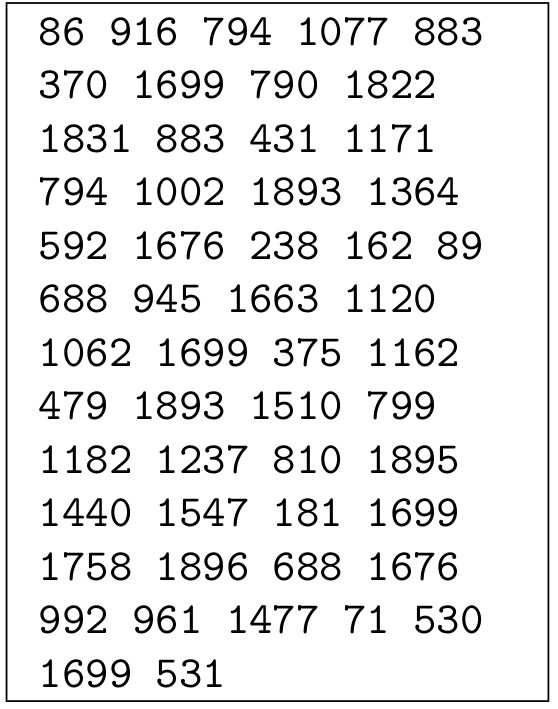

Our vocabulary list was selected by choosing all words which occur at least a 100 times in the spam corpus,
resulting in a list of 1899 words. In practice, a vocabulary list with about 10,000 to 50,000 words is often used.
Given the vocabulary list, we can now map each word in the preprocessed emails into a list of word indices that contains the index of the word in the vocabulary dictionary. The figure below shows the mapping for the sample email. Specifically, in the sample email, the word “anyone” was first normalized to “anyon” and then mapped onto the index 86 in the vocabulary list.

![image.png](attachment:image1.png)

Our task now is to complete the code in the function `processEmail` to perform this mapping. In the code, we are given a string `word` which is a single word from the processed email. We should look up the word in the vocabulary list `vocabList`. If the word exists in the list, we should add the index of the word into the `word_indices` variable. If the word does not exist, and is therefore not in the vocabulary, we can skip the word.

In [237]:
def processEmail(email_contents, verbose=True):
    """
    Preprocesses the body of an email and returns a list of indices 
    of the words contained in the email.    
    
    Parameters
    ----------
    email_contents : str
        A string containing one email. 
    
    verbose : bool
        If True, print the resulting email after processing.
    
    Returns
    -------
    word_indices : list
        A list of integers containing the index of each word in the 
        email which is also present in the vocabulary.
    

    """
    # Load Vocabulary
    vocabList = getVocab()

    # Init return value
    word_indices = []

    # ========================== Preprocess Email ===========================
    # Find the Headers ( \n\n and remove )
    # Uncomment the following lines if you are working with raw emails with the
    # full headers
    # hdrstart = email_contents.find(chr(10) + chr(10))
    # email_contents = email_contents[hdrstart:]

    # Lower case
    email_contents = email_contents.lower()
    
    # Strip all HTML
    # Looks for any expression that starts with < and ends with > and replace
    # and does not have any < or > in the tag it with a space
    email_contents =re.compile('<[^<>]+>').sub(' ', email_contents)

    # Handle Numbers
    # Look for one or more characters between 0-9
    email_contents = re.compile('[0-9]+').sub(' number ', email_contents)

    # Handle URLS
    # Look for strings starting with http:// or https://
    email_contents = re.compile('(http|https)://[^\s]*').sub(' httpaddr ', email_contents)

    # Handle Email Addresses
    # Look for strings with @ in the middle
    email_contents = re.compile('[^\s]+@[^\s]+').sub(' emailaddr ', email_contents)
    
    # Handle $ sign
    email_contents = re.compile('[$]+').sub(' dollar ', email_contents)
    
    # get rid of any punctuation
    email_contents = re.split('[ @$/#.-:&*+=\[\]?!(){},''">_<;%\n\r]', email_contents)

    # remove any empty word string
    email_contents = [word for word in email_contents if len(word) > 0]
    
    # Stem the email contents word by word
    stemmer = utils.PorterStemmer()
    processed_email = []
    for word in email_contents:
        # Remove any remaining non alphanumeric characters in word
        word = re.compile('[^a-zA-Z0-9]').sub('', word).strip()
        word = stemmer.stem(word)
        processed_email.append(word)

        if len(word) < 1:
            continue

        # Look up the word in the dictionary and add to word_indices if found
        # ====================== YOUR CODE HERE ======================
        
        try:
            index = vocabList.index(word)

        except ValueError as s:
            pass
        else:
            word_indices.append(index)

        # =============================================================

    if verbose:
        print('----------------')
        print('Processed email:')
        print('----------------')
        print(' '.join(processed_email))
    return word_indices

In [240]:
#test example
example1 = open(os.path.join('Data', 'emailSample1.txt')).read()
processEmail(example1);

----------------
Processed email:
----------------
anyon know how much it cost to host a web portal well it depend on how mani visitor your expect thi can be anywher from less than number buck a month to a coupl of dollar number you should checkout httpaddr or perhap amazon ec number if your run someth big to unsubscrib yourself from thi mail list send an email to emailaddr


### 2.2 Extracting Features from Emails

We will now implement the feature extraction that converts each email into a vector in $\mathbb{R}^n$. For this exercise, we will be using n = # words in vocabulary list. Specifically, the feature $x_i \in \{0, 1\}$ for an email corresponds to whether the $i^{th}$ word in the dictionary occurs in the email. That is, $x_i = 1$ if the $i^{th}$ word is in the email and $x_i = 0$ if the $i^{th}$ word is not present in the email.

Thus, for a typical email, this feature would look like:

$$ x = \begin{bmatrix} 
0 & \dots & 1 & 0 & \dots & 1 & 0 & \dots & 0 
\end{bmatrix}^T \in \mathbb{R}^n
$$

In [241]:
def emailFeatures(word_indices):
    """
    Takes in a word_indices vector and produces a feature vector from the word indices. 
    
    Parameters
    ----------
    word_indices : list
        A list of word indices from the vocabulary list.
    
    Returns
    -------
    x : list 
        The computed feature vector.
    """
    #number of words in vocabulary list
    n = len(getVocab())
    #initilize feature vector with zero for a given example
    x = np.zeros(n)
    #set 1 to the indices of words in dictionary
    #that also appear in the word_indices
    x[word_indices] = 1
    
    return x

In [ ]:
# Extract Features
with open(os.path.join('Data', 'emailSample1.txt')) as fid:
    file_contents = fid.read()

word_indices  = processEmail(file_contents)
features      = emailFeatures(word_indices)

# Print Stats
print('\nLength of feature vector: %d' % len(features))
print('Number of non-zero entries: %d' % sum(features > 0))

### 2.3 Training SVM for Spam Classification

In the following section we will load a preprocessed training dataset that will be used to train a SVM classifier. The file `spamTrain.mat` (within the `Data` folder for this exercise) contains 4000 training examples of spam and non-spam email, while `spamTest.mat` contains 1000 test examples. Each
original email was processed using the `processEmail` and `emailFeatures` functions and converted into a vector $x^{(i)} \in \mathbb{R}^{1899}$.

After loading the dataset, the next cell proceed to train a linear SVM to classify between spam ($y = 1$) and non-spam ($y = 0$) emails. Once the training completes, we should see that the classifier gets a training accuracy of about 99.8% and a test accuracy of about 98.5%.

In [257]:
#load spam email dataset
from sklearn.metrics import accuracy_score
data = loadmat(os.path.join('Data', 'spamTrain.mat'))
X, y = data["X"], data["y"].flatten()

print('Training linear SVM (SPAM CLASSFICIATION)')

C = 0.1
svc = SVC(C=0.1, kernel='linear')
svc.fit(X, y)
accuracy_score(svc.predict(X), y)

Training linear SVM (SPAM CLASSFICIATION)


0.99825

In [259]:
# Load the test dataset
# You will have Xtest, ytest in your environment
data = loadmat(os.path.join('Data', 'spamTest.mat'))
Xtest, ytest = data['Xtest'].astype(float), data['ytest'][:, 0]

print('Evaluating the linear SVM on the test set')

print('Test Accuracy: %.2f' % (np.mean(svc.predict(Xtest) == ytest) * 100))

Evaluating the linear SVM on the test set
Test Accuracy: 98.90


### 2.4 Top Predictors for Spam

To better understand how the spam classifier works, we can inspect the parameters to see which words the classifier thinks are the most predictive of spam. The next cell finds the parameters with the largest positive values in the classifier and displays the corresponding words similar to the ones shown in the figure below.

<div style="border-style: solid; border-width: 1px; margin: 10px 10px 10px 10px; padding: 10px 10px 10px 10px">
our  click  remov guarante visit basenumb dollar pleas price will nbsp most lo ga hour
</div>

Thus, if an email contains words such as “guarantee”, “remove”, “dollar”, and “price” (the top predictors shown in the figure), it is likely to be classified as spam.

Since the model we are training is a linear SVM, we can inspect the weights learned by the model to understand better how it is determining whether an email is spam or not. The following code finds the words with the highest weights in the classifier. Informally, the classifier 'thinks' that these words are the most likely indicators of spam.

In [268]:
np.argsort??


In [273]:
svc.coef_

array([[ 0.00793208,  0.01563324,  0.05546492, ..., -0.08670606,
        -0.00661274,  0.06506632]])

In [275]:
#indexes of 15 features with largest weights
np.array(getVocab())[np.argsort(svc.coef_.flatten())[::-1][:15]]

array(['our', 'click', 'remov', 'guarante', 'visit', 'basenumb', 'dollar',
       'will', 'price', 'pleas', 'most', 'nbsp', 'lo', 'ga', 'hour'],
      dtype='<U40')

In [296]:
print('Top predictors of spam:')
print('%-15s%-15s'%('Word','Weight'))
print('---'+ ' '*12+'----')
for word, weight in zip(np.array(getVocab())[np.argsort(svc.coef_.flatten())[::-1][:15]], \
                        np.sort(svc.coef_.flatten())[::-1][:15]):
    print('%-15s%.2f'%(word, weight))

Top predictors of spam:
Word           Weight         
---            ----
our            0.50
click          0.47
remov          0.42
guarante       0.38
visit          0.37
basenumb       0.35
dollar         0.32
will           0.27
price          0.27
pleas          0.26
most           0.26
nbsp           0.25
lo             0.25
ga             0.25
hour           0.25


In [303]:
email = open(os.path.join('Data', 'spamSample2.txt')).read()
word_indices = processEmail(email)
x = emailFeatures(word_indices).reshape(1, -1)
svc.predict(x)

----------------
Processed email:
----------------
best bui viagra gener onlin viagra number mg x number pill dollar number free pill reorder discount top sell number qualiti satisfact guarante we accept visa master echeck payment number satisfi custom httpaddr


array([1], dtype=uint8)